In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from NCP.examples.chignolin.schnetpack.train import get_dataset
import ml_confs

from pathlib import Path
import schnetpack
from NCP.examples.chignolin.schnetpack.input_pipeline import TimeLaggedSampler
from NCP.examples.chignolin.schnetpack.model import GraphNCP
import torch
from NCP.utils import to_np, from_np, sqrt_hermitian, cross_cov, filter_reduced_rank_svals
from NCP.examples.chignolin.schnetpack.model import SchNet, SchNet_NCPOperator
from NCP.cdf import smooth_cdf, find_best_quantile
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7
}

plt.rcParams.update(tex_fonts)

In [4]:
def get_cdf(Ux, Vy, fY):
    # observable is a vector to scalar function
    fY = torch.stack([y_i for y_i in torch.unbind(fY, dim=-1)], dim=-1).flatten() # Pytorch equivalent of numpy.apply_along_axis
    candidates = torch.argsort(fY)
    probas = torch.cumsum(torch.ones(fY.shape[0]), -1) / fY.shape[0]  # vector of [k/n], k \in [n]

    Ux, sigma, Vy = whitening(Ux, Vy)
    Ux = Ux.flatten()

    # estimating the cdf of the function f on X_t
    cdf = torch.zeros(candidates.shape[0])
    for i, val in enumerate(fY[candidates]):
        Ify = torch.outer((fY <= val), torch.ones(Vy.shape[1]))  # indicator function of fY < fY[i], put into shape (n_sample, latent_dim)
        EVyFy = torch.mean(Vy * Ify, axis=0)  # for all latent dim, compute E (Vy * fY)
        cdf[i] = probas[i] + torch.sum(sigma * Ux * EVyFy)

    return to_np(fY[candidates].flatten()), to_np(cdf)

In [6]:
def quantile_regression(Ux, Vy, fY, alpha=0.1):
    x, cdf = get_cdf(Ux, Vy, fY)
    cdf = smooth_cdf(x, cdf)
    return find_best_quantile(x, cdf, alpha=alpha)

In [7]:
def compute_data_statistics(Ux, Vy):
    sigma = torch.sqrt(torch.exp(-model.model.S.weights ** 2))
    sigma = sigma.unsqueeze(1)
    sigma = sigma.repeat(1, 39).ravel()
    model.model._mean_Ux = torch.mean(Ux, axis=0)
    model.model._mean_Vy = torch.mean(Vy, axis=0)

    Ux_centered = Ux - torch.outer(torch.ones(Ux.shape[0]).type_as(Ux), model.model._mean_Ux)
    Vy_centered = Vy - torch.outer(torch.ones(Vy.shape[0]).type_as(Vy), model.model._mean_Vy)

    Ux_centered = Ux_centered @ torch.diag(sigma)
    Vy_centered = Vy_centered @ torch.diag(sigma)

    cov_X = torch.cov(Ux_centered.T)
    cov_Y = torch.cov(Vy_centered.T)
    cov_XY = cross_cov(Ux_centered.T, Vy_centered.T)

    # write in a stable way
    model.model._sqrt_cov_X_inv = torch.linalg.pinv(sqrt_hermitian(cov_X))
    model.model._sqrt_cov_Y_inv = torch.linalg.pinv(sqrt_hermitian(cov_Y))

    M = model.model._sqrt_cov_X_inv @ cov_XY @ model.model._sqrt_cov_Y_inv
    e_val, sing_vec_l = torch.linalg.eigh(M @ M.T)
    e_val, model.model._sing_vec_l = filter_reduced_rank_svals(e_val, sing_vec_l)
    model.model._sing_val = torch.sqrt(e_val)
    model.model._sing_vec_r = (M.T @ model.model._sing_vec_l) / model.model._sing_val

In [8]:
def whitening(Ux, Vy):
    sigma = torch.sqrt(torch.exp(-model.model.S.weights ** 2))
    sigma = sigma.unsqueeze(1)
    sigma = sigma.repeat(1, 39).ravel()
    
    Ux = Ux - torch.outer(torch.ones(Ux.shape[0]), model.model._mean_Ux)
    Ux = Ux @ torch.diag(sigma)
    Ux = Ux @ model.model._sqrt_cov_X_inv @ model.model._sing_vec_l

    Vy = Vy - torch.outer(torch.ones(Vy.shape[0]), model.model._mean_Vy)
    Vy = Vy @ torch.diag(sigma)
    Vy = Vy @ model.model._sqrt_cov_Y_inv @ model.model._sing_vec_r

    return Ux, model.model._sing_val, Vy

In [9]:
def conditional_expectation(Ux, Vy, fY):
    Ux, sigma, Vy = whitening(Ux, Vy)
    bias = torch.mean(fY, axis=0)

    fY = fY.unsqueeze(-1).repeat((1,1,Vy.shape[-1]))
    Vy = Vy.unsqueeze(1).repeat((1, fY.shape[1], 1))
    Ux = Ux.unsqueeze(1).repeat((1, fY.shape[1], 1))

    Vy_fY = torch.mean(Vy * fY, axis=0)
    sigma_U_fY_VY = sigma * Ux * Vy_fY
    val = torch.sum(sigma_U_fY_VY, axis=-1)

    return to_np(bias + val)

In [10]:
configs = ml_confs.from_file('configs.yaml')
configs.tabulate()

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Key              ┃ Value                     ┃ Type  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ selection        │ backbone                  │ str   │
│ data_path        │ chignolin/schnetpack/data │ str   │
│ n_final_features │ 16                        │ int   │
│ n_atom_basis     │ 64                        │ int   │
│ n_interactions   │ 3                         │ int   │
│ n_rbf            │ 20                        │ int   │
│ cutoff           │ 5.0                       │ float │
│ batch_size       │ 256                       │ int   │
│ lagtime          │ 1                         │ int   │
│ max_epochs       │ 5                         │ int   │
│ gamma            │ 0.001                     │ float │
│ seed             │ 0                         │ int   │
└──────────────────┴───────────────────────────┴───────┘

In [11]:
db_path = Path.joinpath(Path.cwd(),'data/CLN025-0-protein_backbone.db')

#Data loading
dataset = get_dataset(db_path, configs.cutoff)
dt = 200
t_ax = np.arange(0,len(dataset)*dt,dt)
batch_sampler = TimeLaggedSampler(dataset, batch_size = configs.batch_size, lagtime = configs.lagtime, shuffle = True)
dataloader = schnetpack.data.AtomsLoader(dataset, batch_sampler=batch_sampler, num_workers=12, persistent_workers=True)
dataloader = schnetpack.data.AtomsLoader(dataset, batch_size=10)
NCP_model = SchNet_NCPOperator(U_operator=SchNet, U_operator_configs=configs)

/Users/gturri/opt/anaconda3/envs/kooplearn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
dataset = get_dataset(db_path, configs.cutoff)
n_train = round(len(dataset)*0.8)
n_test = round(len(dataset)*0.1)
n_val = round(len(dataset)*0.1)

train_dataset = torch.utils.data.Subset(dataset, range(n_train))
test_dataset = torch.utils.data.Subset(dataset, range(n_train, n_train + n_val))
t_test = t_ax[range(n_train, n_train + n_val)]
val_dataset = torch.utils.data.Subset(dataset, range(n_train + n_val, n_train + n_val + n_test))

In [14]:
optimizer = torch.optim.Adam
optimizer_kwargs = {'lr': 1e-3}
n_atoms = dataset[0][schnetpack.properties.n_atoms].item()

model = GraphNCP(
    NCP_model,
    configs,
    n_atoms,
    optimizer,
    optimizer_kwargs
)

/Users/gturri/opt/anaconda3/envs/kooplearn/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [16]:
model = GraphNCP.load_from_checkpoint('NCP_model.ckpt', configs=configs, optimizer = torch.optim.Adam)

In [17]:
model

GraphNCP(
  (model): SchNet_NCPOperator(
    (U): SchNet(
      (postprocessors): ModuleList()
      (pwise_dist): PairwiseDistances()
      (radial_basis): GaussianRBF()
      (net): SchNet(
        (radial_basis): GaussianRBF()
        (cutoff_fn): CosineCutoff()
        (embedding): Embedding(100, 64, padding_idx=0)
        (interactions): ModuleList(
          (0-2): 3 x SchNetInteraction(
            (in2f): Dense(
              in_features=64, out_features=64, bias=False
              (activation): Identity()
            )
            (f2out): Sequential(
              (0): Dense(in_features=64, out_features=64, bias=True)
              (1): Dense(
                in_features=64, out_features=64, bias=True
                (activation): Identity()
              )
            )
            (filter_network): Sequential(
              (0): Dense(in_features=20, out_features=64, bias=True)
              (1): Dense(
                in_features=64, out_features=64, bias=True
           

In [18]:
model = model.to('cpu')

In [20]:
lagtime = 20

In [21]:
Ux_train = []
Vy_train = []
with torch.no_grad():
    # for i in tqdm(range(len(train_dataset)//lagtime)):
    for i in tqdm(range(10000)):
        Ux_train.append(model(train_dataset[i*lagtime])["scalar_representation"].ravel())
        Vy_train.append(model(train_dataset[(i+1)*lagtime])["scalar_representation"].ravel())
Ux_train = torch.stack(Ux_train)
Vy_train = torch.stack(Vy_train)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
compute_data_statistics(Ux_train, Vy_train)

In [23]:
Vy = []
fY = []
with torch.no_grad():
    # for i in tqdm(range(len(train_dataset)//lagtime)):
    for i in tqdm(range(10000)):
        out = model(train_dataset[(i+1)*lagtime])
        Vy.append(out["scalar_representation"].ravel())   
        fY.append(torch.linalg.norm(out['_Rij'],dim=1).mean())
Vy = torch.stack(Vy)
fY = torch.stack(fY)[:,None]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
Ux = []
truth = []
pred_quantiles = []
t_plot = []
with torch.no_grad():
    # for i in tqdm(range(len(test_dataset)//lagtime)):
    for i, t in enumerate(tqdm(np.arange(500,1500))):
        out = model(test_dataset[t*lagtime])
        Ux.append(out["scalar_representation"].ravel()[None,:])
        truth.append(torch.linalg.norm(out['_Rij'],dim=1).mean())
        pred_quantiles.append(quantile_regression(Ux[i], Vy, fY, alpha=0.1))
        t_plot.append(t_test[t*lagtime])
Ux = torch.stack(Ux).squeeze()
truth = torch.stack(truth)
pred_quantiles = np.stack(pred_quantiles).squeeze()
t_plot = np.array(t_plot)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
preds = conditional_expectation(Ux, Vy, fY)

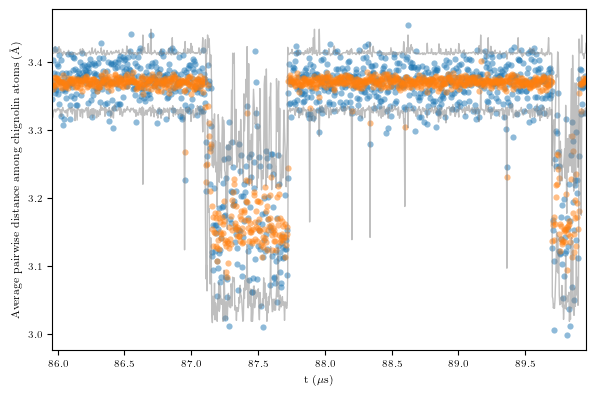

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

ax.scatter(t_plot*1e-6, truth,alpha=0.5, linewidth=0, s=20)
ax.scatter(t_plot*1e-6, preds, alpha=0.5, linewidth=0, s=20)
ax.plot(t_plot*1e-6, pred_quantiles[:,0], alpha=0.5, linewidth=1, color='gray')
ax.plot(t_plot*1e-6, pred_quantiles[:,1], alpha=0.5, linewidth=1, color='gray')

ax.set_xmargin(0)

ax.set_ylabel(r"Average pairwise distance among chignolin atoms (\r{A})")
ax.set_xlabel(r"t ($\mu$s)")

plt.tight_layout()
plt.show()
fig.savefig('chignolin.pdf', bbox_inches='tight')